# Classification of age groups using functional connectivity
The resulting connectivity coefficients can be used to discriminate children from adults.

In [13]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker
from matplotlib import pyplot as plt
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import GraphicalLassoCV
from nilearn import plotting, image
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [3]:
#Load brain development fMRI dataset and MSDL atlas
dataset_development = datasets.fetch_development_fmri(n_subjects=30)
atlas_msdl = datasets.fetch_atlas_msdl()
msdl_coords = atlas_msdl.region_coords

D:\anaconda\envs\mne\lib\site-packages\numpy\lib\npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [4]:
msdl_atlas_masker = NiftiMapsMasker(atlas_msdl.maps, resampling_target="data", t_r=2, detrend=True, low_pass=.1, high_pass=.01)
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in zip(dataset_development.func, dataset_development.confounds, dataset_development.phenotypic):
    time_series = msdl_atlas_masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])
print('Data has {0} children.'.format(len(children)))

Data has 24 children.


# Correlation

In [5]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(children)
mean_correlation_matrix = correlation_measure.mean_

NameError: name 'plotting' is not defined

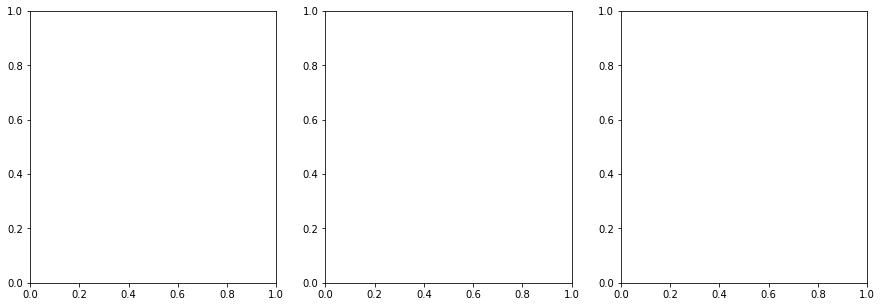

In [6]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='correlation, child {}'.format(i))

In [7]:
np.fill_diagonal(mean_correlation_matrix, 0)
plotting.plot_connectome(mean_correlation_matrix, msdl_coords, edge_threshold="90%", title='mean correlation over all children')

NameError: name 'plotting' is not defined

# Partial correlations

In [8]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrices = partial_correlation_measure.fit_transform(children)

NameError: name 'plotting' is not defined

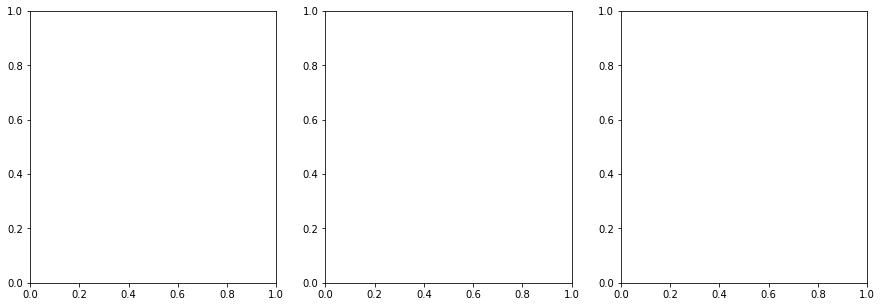

In [9]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='partial correlation, child {}'.format(i))

In [10]:
plotting.plot_connectome(partial_correlation_measure.mean_, msdl_coords, edge_threshold="90%", title='mean partial correlation over all children')

NameError: name 'plotting' is not defined

# Tangent space embedding

NameError: name 'plotting' is not defined

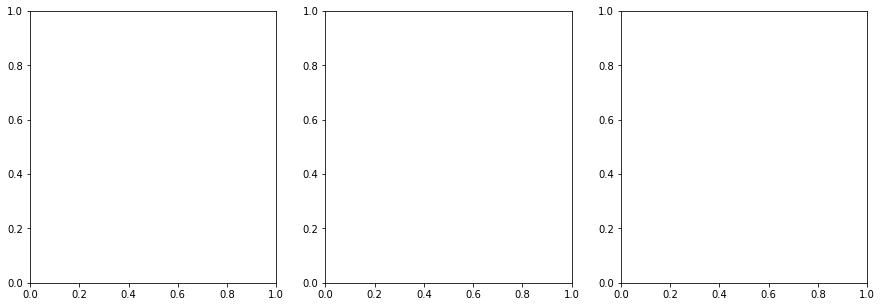

In [11]:
tangent_measure = ConnectivityMeasure(kind='tangent')
tangent_matrices = tangent_measure.fit_transform(children)
mean_tangent_matrix = tangent_measure.mean_
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='tangent offset, child {}'.format(i))

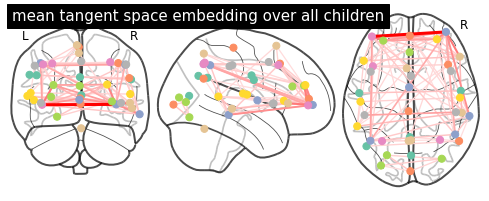

In [37]:
plotting.plot_connectome(mean_tangent_matrix, msdl_coords, edge_threshold="90%", title='mean tangent space embedding over all children')

# What kind of connectivity is most powerful for classification?
We will use connectivity matrices as features to distinguish children from adults. 

In [14]:
kinds = ['correlation', 'partial correlation', 'tangent', 'sparse inverse']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

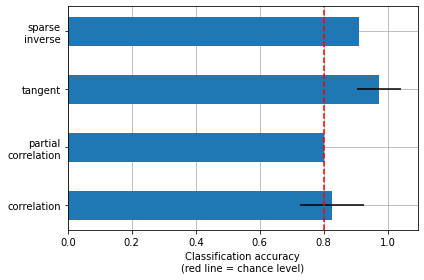

In [31]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()